## Figure 7

Bar chart showing a) LWP, b) effective radius, and c) cloud albedo for different conditions. 

Bars divided into different climate conditions:
- slow vs. fast updraft: w
- clean vs. polluted environment: Na
- large vs. small aerosol: ra
- organic rich vs. poor: Forg

and different bars for each assumption of surface partitioning, including constant surface tension. 

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open_atmos_jupyter_utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
import os
from joblib import Parallel, delayed
import pickle as pkl

from matplotlib import pyplot
from matplotlib.colors import TwoSlopeNorm
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling

from PySDM_examples.Singer_Ward import Settings, ParcelSimulation
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark
from PySDM_examples.Singer_Ward.constants_def import SINGER_CONSTS, plot_colors, plot_lines, plot_names
from PySDM_examples.Singer_Ward.read_mcmc import get_dict_median_parameters

# import warnings
# from numba.core.errors import NumbaExperimentalFeatureWarning

In [3]:
conditions = ("slow", "fast", "clean", "polluted", "small", "large", "poor", "rich")
models = ('Constant', 'CompressedFilmOvadnevaite', 'SzyszkowskiLangmuir', 'CompressedFilmRuehl')

def c2p(c):
    w = 0.5
    N_a = 100
    r_a = 40
    Forg = 0.5
    match c:
        case "slow":
            w = 0.05
        case "fast":
            w = 5
        case "clean":
            N_a = 50
        case "polluted":
            N_a = 400
        case "small":
            r_a = 20
        case "large":
            r_a = 80
        case "poor":
            Forg = 0.2
        case "rich":
            Forg = 0.8

    return {"w":w, "N_a":N_a, "r_a":r_a, "Forg":Forg}

FORMULAE = Formulae(constants=SINGER_CONSTS)
WATER_MOLAR_VOLUME = FORMULAE.constants.water_molar_volume
aerosol_default = AerosolBetaCaryophylleneDark(water_molar_volume=WATER_MOLAR_VOLUME)
Ntotal, Ncut = 1000, 500

def genkey(condition, model):
    return f"{condition}_{model}"

In [4]:
save = False
restore_saved_data = False

if restore_saved_data:
    with open('data_fig7.pkl','rb') as file:
        output = pkl.load(file)
else:
    def compute(key, settings):
        simulation = ParcelSimulation(settings)
        output = simulation.run()
        model = key.split("_")[-1]
        output['updraft'] = settings.w
        output['org_fraction'] = settings.aerosol.modes[0]['f_org']
        output['color'] = plot_colors[model]
        return key, output

    print(f'tasks scheduled: {len(models) * len(conditions)}')
    output = dict(Parallel(verbose=10, n_jobs=-1)(
        delayed(compute)(genkey(cond, model), Settings(
            dz = 1 * si.m,
            n_sd_per_mode = 100,
            model = model,
            aerosol = AerosolBetaCaryophylleneDark(
                water_molar_volume=WATER_MOLAR_VOLUME,
                Forg=c2p(cond)["Forg"],
                N_a=c2p(cond)["N_a"],
                r_a=c2p(cond)["r_a"]
            ),
            w = c2p(cond)["w"] * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
            stc = get_dict_median_parameters(model, aerosol_default, Ntotal, Ncut),

        ))
        for cond in conditions
        for model in models
    ))

    if save:
        with open('data_fig7.pkl','wb') as file:
            pkl.dump(output, file)

tasks scheduled: 32


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed:  3.5min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed:  3.7min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:  4.2min remaining:   26.2s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  4.4min finished


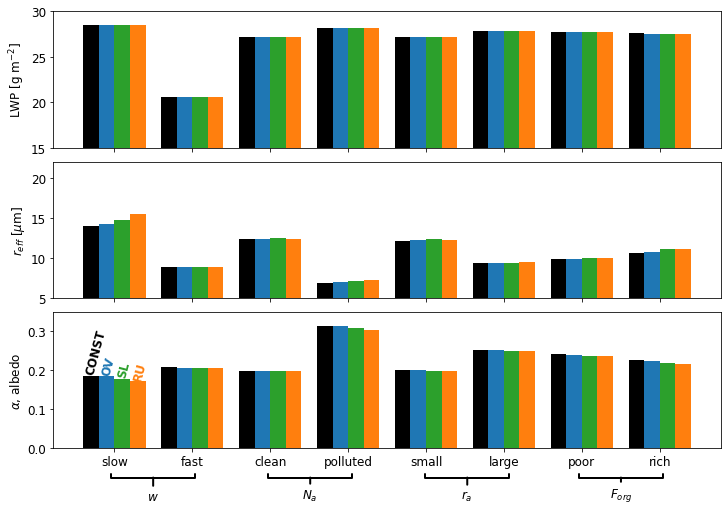

In [6]:
fig, axes = pyplot.subplots(3, 1, figsize=(10, 7), sharex=True, constrained_layout=True)
pyplot.rcParams.update({"font.size":12})

bar_width = 0.1
vars = ("lwp", "reff", "albedo")
labels = ("LWP [g m$^{-2}$]", "$r_{eff}$ [$\mu$m]", "$\\alpha$, albedo")
ylim = ((15,30), (5,22), (0,0.35))
units = (si.g / si.m**2, si.um, si.dimensionless)

x_cond = {"slow":0, "fast":1, "clean":2, "polluted":3, "small":4, "large":5, "poor":6, "rich":7}
x_model = {'Constant':0, 'CompressedFilmOvadnevaite':1, 'SzyszkowskiLangmuir':2, 'CompressedFilmRuehl':3}


for i, ax in enumerate(axes):
    for key, output_k in output.items():
        cond, model = key.split("_")

        cloud_top_index = -1
        x = x_cond[cond]*5*bar_width + x_model[model]*bar_width + bar_width/2
        y = in_unit(output_k[vars[i]][cloud_top_index], units[i]) if type(output_k[vars[i]]) != float \
            else in_unit(output_k[vars[i]], units[i])

        if cond == "slow":
            ax.bar(x, y, color=plot_colors[model], width=bar_width, label=plot_names[model])
        else:
            ax.bar(x, y, color=plot_colors[model], width=bar_width)

        ax.set_xticks([x_cond[cond]*5*bar_width + 2*bar_width for cond in conditions])
        ax.set_xticklabels(conditions)
        if i == 2 and cond == "slow":
            ax.text(x - 0.45*bar_width, y*1.04, plot_names[model], rotation=75, color=plot_colors[model], weight="bold")

    ax.set_ylabel(labels[i])
    ax.set_ylim(ylim[i])
    # if i == 0:
    #     ax.legend(fontsize=10)

    yoffset = -0.2
    if i == 2:
        ax.annotate('$w$', xy=(0.3*5*bar_width, yoffset), xytext=(0.3*5*bar_width, 2*yoffset),
            fontsize=12, ha='center', va='bottom', xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=.3', lw=2.0))

        ax.annotate('$N_a$', xy=(0.77*5*bar_width, yoffset), xytext=(0.77*5*bar_width, 2*yoffset),
            fontsize=12, ha='center', va='bottom', xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=.3', lw=2.0))

        ax.annotate('$r_a$', xy=(1.24*5*bar_width, yoffset), xytext=(1.24*5*bar_width, 2*yoffset),
            fontsize=12, ha='center', va='bottom', xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=.3', lw=2.0))

        ax.annotate('$F_{org}$', xy=(1.7*5*bar_width, yoffset), xytext=(1.7*5*bar_width, 2*yoffset),
            fontsize=12, ha='center', va='bottom', xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=.3', lw=2.0))

# show_plot("fig7.pdf")

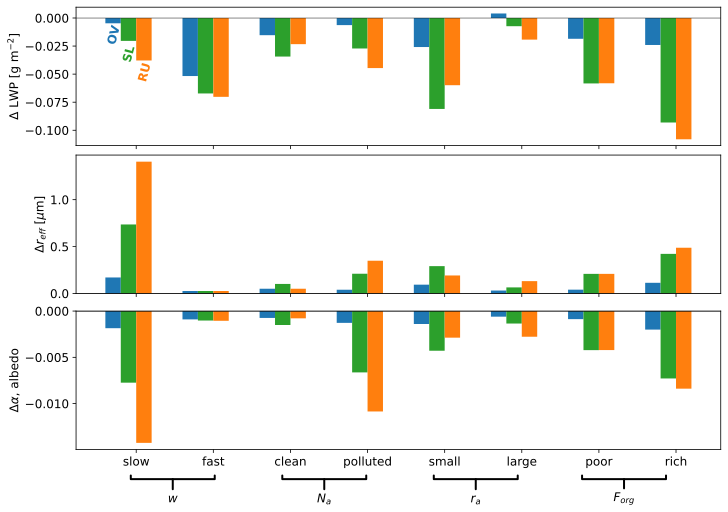

HTML(value="<a href='./fig7_constdiff.pdf' target='_blank'>./fig7_constdiff.pdf</a><br>")

In [26]:
fig, axes = pyplot.subplots(3, 1, figsize=(10, 7), sharex=True, constrained_layout=True)
pyplot.rcParams.update({"font.size":12})

bar_width = 0.1
vars = ("lwp", "reff", "albedo")
labels = ("$\Delta$ LWP [g m$^{-2}$]", "$\Delta r_{eff}$ [$\mu$m]", "$\Delta \\alpha$, albedo")
units = (si.g / si.m**2, si.um, si.dimensionless)

x_cond = {"slow":0, "fast":1, "clean":2, "polluted":3, "small":4, "large":5, "poor":6, "rich":7}
x_model = {'CompressedFilmOvadnevaite':0, 'SzyszkowskiLangmuir':1, 'CompressedFilmRuehl':2}

for i, ax in enumerate(axes):
    for key, output_k in output.items():
        cond, model = key.split("_")

        if model == "Constant":
            continue

        key_const = key.replace(model,"Constant")
        output_const = output[key_const]

        cloud_top_index = -1
        x = x_cond[cond]*5*bar_width + x_model[model]*bar_width + bar_width/2
        y = in_unit(output_k[vars[i]][cloud_top_index] - output_const[vars[i]][cloud_top_index], units[i]) \
            if type(output_k[vars[i]]) != float \
            else in_unit(output_k[vars[i]] - output_const[vars[i]], units[i])

        if cond == "slow":
            ax.bar(x, y, color=plot_colors[model], width=bar_width, label=plot_names[model])
        else:
            ax.bar(x, y, color=plot_colors[model], width=bar_width)

        ax.set_xticks([x_cond[cond]*5*bar_width + 2*bar_width for cond in conditions])
        ax.set_xticklabels(conditions)
        if i == 0 and cond == "slow":
            ax.text(x - 0.45*bar_width, y-0.018, plot_names[model], rotation=75, color=plot_colors[model], weight="bold")

    ax.set_ylabel(labels[i])
    ax.axhline(0, color="k", lw=0.5)

    yoffset = -0.2
    if i == 2:
        ax.annotate('$w$', xy=(0.3*5*bar_width, yoffset), xytext=(0.3*5*bar_width, 2*yoffset),
            fontsize=12, ha='center', va='bottom', xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=.3', lw=2.0))

        ax.annotate('$N_a$', xy=(0.77*5*bar_width, yoffset), xytext=(0.77*5*bar_width, 2*yoffset),
            fontsize=12, ha='center', va='bottom', xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=.3', lw=2.0))

        ax.annotate('$r_a$', xy=(1.24*5*bar_width, yoffset), xytext=(1.24*5*bar_width, 2*yoffset),
            fontsize=12, ha='center', va='bottom', xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=.3', lw=2.0))

        ax.annotate('$F_{org}$', xy=(1.7*5*bar_width, yoffset), xytext=(1.7*5*bar_width, 2*yoffset),
            fontsize=12, ha='center', va='bottom', xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=.3', lw=2.0))

show_plot("fig7_constdiff.pdf")